# Fake News Detection

In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report

In [2]:
from sklearn.svm import LinearSVC
from lightgbm import LGBMClassifier
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import ExtraTreeClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from urllib.request import urlopen

### Data set from  https://www.kaggle.com/code/therealsampat/fake-news-detection/data

In [3]:
df_fake = pd.read_csv('Fake.csv')
df_true = pd.read_csv('True.csv')

df_fake['label'] = 0
df_true['label'] = 1

df = pd.concat([df_fake, df_true], axis=0)
df.head()

,title,text,subject,date,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0


In [4]:
df.drop(['subject', 'date'], axis=1, inplace=True)
df.head()

,title,text,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,0


### Counting the numbers of fake news and the real news (label = 0 and 1)

In [5]:
df['label'] = df['label'].astype('int8')
labels = df['label'].value_counts().reset_index()
labels

,index,label
0,0,23481
1,1,21417


### Fake and real news distribution in data set

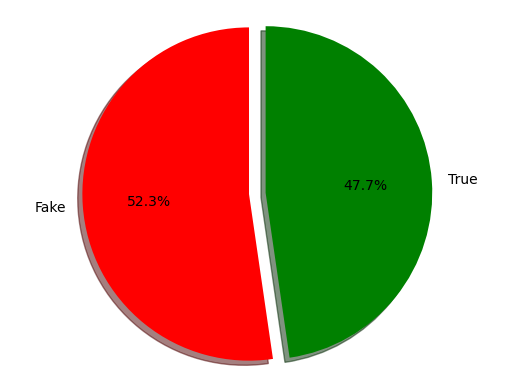

In [6]:
names = 'Fake', 'True'
values = list(labels['label'])

labels = names
sizes = values
explode = (0, 0.1)

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90, colors = ['red', 'green'])
ax1.axis('equal')  

plt.show()

### Putting the title and news test together and getting rid of the 'text' column

In [7]:
df['all_text'] = df['title'] + df['text']
df.drop(['text'], axis=1, inplace=True)

### Using only 30% of the data set, because set size has little impact on the final result

In [8]:
df = df.sample(frac=0.3)
labels = df['label'].value_counts().reset_index()
labels

,index,label
0,0,7117
1,1,6352


## Preprocess text before using it in prediction model.

In [9]:
# loading packages for Stemmer und Lemmatizer
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import stopwords
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [10]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
exclist = string.punctuation + string.digits
table_ = str.maketrans('', '', exclist)

def preprocess(raw_text):
    oldtext = raw_text.lower()
    table_ = str.maketrans('', '', exclist)
    newtext = oldtext.translate(table_)
    tokens = nltk.word_tokenize(newtext)
    tokens = [w for w in tokens if not w in stop_words]
    tokens = [w for w in tokens if not w.isdigit()]
    tokens = [w for w in tokens if w.isalpha()] 
    tokens = [lemmatizer.lemmatize(word, pos='v') for word in tokens] 
    return tokens

In [11]:
# rejoining all words after lemmatizing back into one text

def rejoin_words(tokenized_column):
    return ( " ".join(tokenized_column))

In [12]:
df["lemmatized"] = df["all_text"].apply(preprocess)
df['all_text'] = df.apply(lambda x: rejoin_words(x['lemmatized']), axis=1)
df.drop(['lemmatized'], axis=1, inplace=True)
df[['title', 'all_text', 'label']].head()

,title,all_text,label
6723,"From Syria to North Korea, Tillerson would inh...",syria north korea tillerson would inherit mess...,1
4327,Trump national security aide McFarland may bec...,trump national security aide mcfarland may bec...,1
261,Hilarious Video Shows The Moment Bernie Disco...,hilarious video show moment bernie discover re...,0
20995,HOOKERS FOR HILLARY: Why They’ve Got Her Back…...,hookers hillary get seem fit openly immoral gr...,0
20499,NOT KIDDING! OBAMA Agrees To Turkey’s Demands…...,kid obama agree turkey troop order wear mark i...,0


## Training the model using Pipeline and choosing the Classifier

In [13]:
X = df['all_text']
y = df['label']

In [14]:
classifiers = {}
classifiers.update({"DummyClassifier": DummyClassifier(strategy='most_frequent')})
classifiers.update({"LinearSVC": LinearSVC()})
classifiers.update({"MultinomialNB": MultinomialNB()})
classifiers.update({"RandomForestClassifier": RandomForestClassifier()})
classifiers.update({"DecisionTreeClassifier": DecisionTreeClassifier()})
classifiers.update({"ExtraTreeClassifier": ExtraTreeClassifier()})
classifiers.update({"AdaBoostClassifier": AdaBoostClassifier()})
classifiers.update({"KNeighborsClassifier": KNeighborsClassifier()})
classifiers.update({"BernoulliNB": BernoulliNB()})

In [15]:
df_models = pd.DataFrame(columns=['model', 'run_time', 'roc_auc', 'roc_auc_std'])

for key in classifiers:
    
    start_time = time.time()
    
    pipeline = Pipeline([("tfidf", TfidfVectorizer()), ("clf", classifiers[key] )])
    
    cv = cross_val_score(pipeline, X, y, cv=5, scoring='roc_auc')

    row = {'model': key,
           'run_time': format(round((time.time() - start_time)/60,2)),
           'roc_auc': cv.mean(),
           'roc_auc_std': cv.std(),
    }
    
    df_models.loc[len(df_models)] = row
    
    
df_models = df_models.sort_values(by='roc_auc', ascending=False)

In [16]:
df_models.head(15)

,model,run_time,roc_auc,roc_auc_std
1,LinearSVC,0.19,0.998791,0.000248
6,AdaBoostClassifier,1.0,0.998087,0.000684
3,RandomForestClassifier,0.91,0.997564,0.000487
8,BernoulliNB,0.18,0.987543,0.001730
2,MultinomialNB,0.18,0.979575,0.002661
4,DecisionTreeClassifier,0.77,0.972713,0.002532
7,KNeighborsClassifier,0.34,0.927041,0.005875
5,ExtraTreeClassifier,0.19,0.771502,0.010934
0,DummyClassifier,0.18,0.500000,0.000000


## The best classifier is LinearSVC()

### Using the LinearSVC() for prediction

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=22, shuffle=True)

In [18]:
bundled_pipeline = Pipeline([("tfidf", TfidfVectorizer()), ("clf", LinearSVC())])
bundled_pipeline.fit(X_train, y_train)
y_pred = bundled_pipeline.predict(X_test)

In [19]:
print(classification_report(y_test, y_pred))
print('Accuracy:',accuracy_score(y_test, y_pred))
print('F1 score:',f1_score(y_test, y_pred))
print('ROC/AUC score:',roc_auc_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.98      0.99      2166
           1       0.98      0.99      0.98      1875

    accuracy                           0.98      4041
   macro avg       0.98      0.98      0.98      4041
weighted avg       0.98      0.98      0.98      4041

Accuracy: 0.9846572630536996
F1 score: 0.9835018626929217
ROC/AUC score: 0.984720590951062


## Testing our model for real news from web-sites

In [20]:
def output_lable(n):
    if n == 0:
        return "Fake News"
    elif n == 1:
        return "Not A Fake News"
    
def manual_testing(news):
    testing_news = {"text":[news]}
    new_def_test = pd.DataFrame(testing_news)
    new_def_test["text"] = new_def_test["text"].apply(preprocess)
    new_def_test['all_text'] = new_def_test.apply(lambda x: rejoin_words(x['text']), axis=1)
    new_xv_test = new_def_test["all_text"]
        
    y_pred = bundled_pipeline.predict(new_xv_test)
    
    return print(output_lable(y_pred))

### Real news was taken from the site https://edition.cnn.com/2022/12/07/politics/trump-immunity-lawsuits-appeal-january-6


In [21]:
real_ = "Washington CNN A federal court of appeals in DC spent nearly two hours on Wednesday grappling with whether former President Donald Trump should be immune from liability in three separate lawsuits stemming from the January 6, 2021, insurrection.A federal judge in Washington, DC, ruled in February that the lawsuits can move forward, denying Trump’s claim that his conduct was shielded by the privileges of the presidency. But his attorney, Jesse Binnall, urged a three-judge panel of the DC Circuit Court of Appeals to overturn that decision, arguing his client was using the so-called bully pulpit when he spoke to his supporters the morning of the attack, and that the speech deployed under that cover shields Trump from the lawsuits. “It is very normal for a president to comment on any number of things,” Binnall told the court, adding that it’s “especially important that we protect the president’s right to” execute the duties of his office. Binnall argued that civil liability was not the correct remedy for individuals taking issue with things a president says. Instead, he stressed that the correct remedy would be the impeachment process as set forth in the Constitution. He said that Trump being denied immunity in the cases will have a chilling effect on future presidential speech as it would open presidents up to a slew of lawsuits from opponents. (Before leaving office, Trump was impeached by House Democrats for inciting the riot but was later acquitted by the Senate.)The three lawsuits were filed last year by Democratic members of the House and by police officers who defended the US Capitol on January 6, with the suits claiming Trump prompted his supporters to attack."
manual_testing(real_)

Not A Fake News


### Fake news was taken from the site https://money.cnn.com/2016/11/02/media/fake-news-stories/index.html

In [22]:
fake_ = 'In October, a story claimed that "tens of thousands" of fraudulent ballots had been found in a warehouse in Ohio. The ballots had supposedly been cast for Hillary Clinton and were found inside sealed ballot boxes that would be counted alongside real election ballot boxes.The story, first published online by the Christian Times Newspaper, was disproven by Snopes -- but not before it went viral.One website version of the story was shared with over 6.1 million people, according to Crowdtangle, which tracks the reach and performance of social media posts.'
manual_testing(fake_)

Fake News


## The most frequent words in fake and in real news

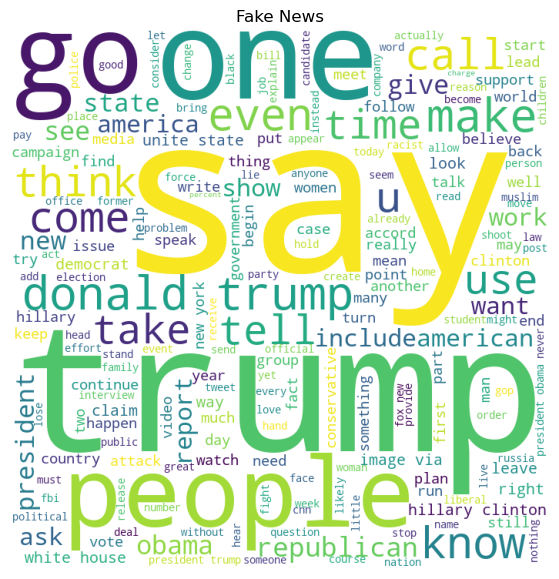

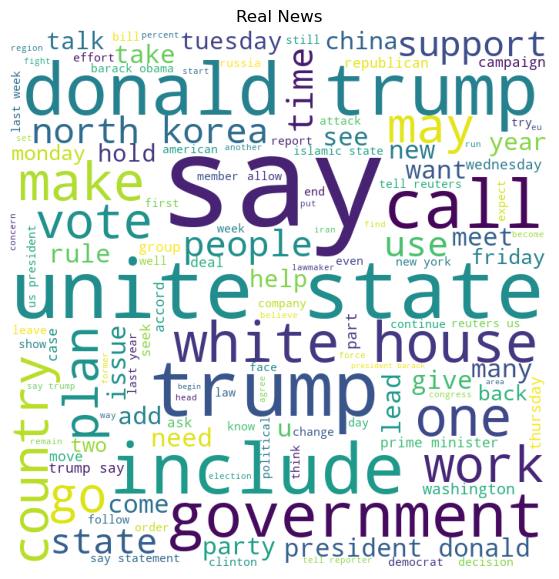

In [23]:
fnews_text = ''
fnews_text = ' '.join(df[df['label'] == 0]['all_text'])
rnews_text = ''
rnews_text = ' '.join(df[df['label'] == 1]['all_text'])

wordcloud_fake = WordCloud(width = 700, height = 700,
                          background_color ='white', 
                          min_font_size = 10).generate(fnews_text)
wordcloud_true = WordCloud(width = 700, height = 700,
                          background_color ='white', 
                          min_font_size = 10).generate(rnews_text)

plt.figure(figsize = [8, 7])
plt.imshow(wordcloud_fake)
plt.axis('off')
plt.title('Fake News')
plt.show()

plt.figure(figsize = [8, 7])
plt.imshow(wordcloud_true)
plt.axis('off')
plt.title('Real News')
plt.show()

# The words frequency in real and fake news

In [24]:
from nltk.probability import FreqDist

In [25]:
fdist = FreqDist(fnews_text.split())
fdist_fnews = fdist.most_common(25)

In [26]:
fdist = FreqDist(rnews_text.split())
fdist_rnews = fdist.most_common(25)

In [27]:
fdist_rnews_list = [x[0] for x in fdist_rnews]
fdist_fnews_list = [x[0] for x in fdist_fnews]

## Common words in (most common 25 words) in real and fake news

In [28]:
list(set(fdist_rnews_list) & set(fdist_fnews_list))

['people',
 'us',
 'one',
 'would',
 'new',
 'make',
 'president',
 'state',
 'tell',
 'say',
 'take',
 'also',
 'trump']

## Unique words for fake and real news

In [51]:
print('Fake News words:', list(set(fdist_fnews_list) - set(fdist_rnews_list)))
print()
print('Real News words:', list(set(fdist_rnews_list) - set(fdist_fnews_list)))

Fake News words: ['hillary', 'white', 'news', 'even', 'clinton', 'time', 'get', 'obama', 'go', 'donald', 'know', 'like']

Real News words: ['call', 'reuters', 'house', 'party', 'unite', 'include', 'vote', 'last', 'government', 'could', 'republican', 'campaign']


# Part II

# Detect the Vader Sentiment using 'SentimentIntensityAnalyzer'

In [30]:
df['label'] = df['label'].map({0:'Fake', 1:'True'})

In [31]:
# Import the lexicon 
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Create an instance of SentimentIntensityAnalyzer
sent_analyzer = SentimentIntensityAnalyzer()

In [32]:
# get the polarity of sentiment 
#         "negative" < = 0.5
# 0.5 < = "neutral"  < = 0.5
#         "positive" > = 0.5

def format_output(output_dict):
  
  polarity = "neutral"

  if(output_dict['compound']>= 0.05):
    polarity = "positive"

  elif(output_dict['compound']<= -0.05):
    polarity = "negative"

  return polarity


def predict_sentiment(text):
  output_dict =  sent_analyzer.polarity_scores(text)

  return format_output(output_dict)

In [33]:
# Run the predictions
df["vader_title_prediction"] = df['title'].apply(predict_sentiment)
df["vader_text_prediction"] = df['all_text'].apply(predict_sentiment)

# Show 5 random rows of the data
df.sample(5)

,title,label,all_text,vader_title_prediction,vader_text_prediction
14557,WOW! HILLARY’S GOT GOVERNOR OF IOWA Shakin’ In...,Fake,wow hillary get governor iowa shakin boot afra...,positive,negative
3020,Civil Rights Icon Drops Mic On Incoming Trump...,Fake,civil right icon drop mic incoming trump presi...,negative,positive
9692,Maverick Mexico governor tips Trump to win U.S...,True,maverick mexico governor tip trump win us pres...,positive,positive
15123,Which GOP Candidates Own Guns And How Does The...,Fake,gop candidates gun nra rate themrepublican pre...,neutral,negative
10334,MAXINE WATERS: ‘These people trying to ‘discre...,Fake,maxine water people try discredit videomaxine ...,neutral,positive


### Vader sentimen prediction for news titels

Text(0.5, 0.98, 'Vader title sentiment prediction')

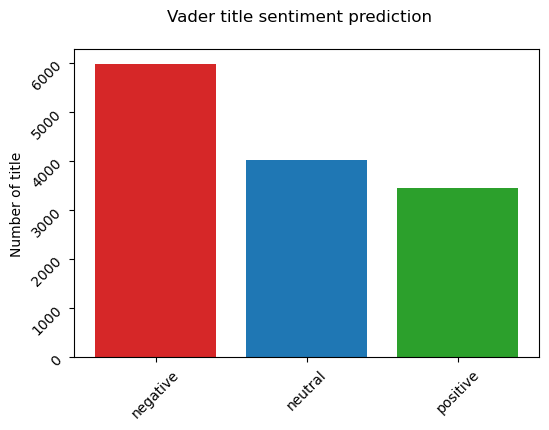

In [34]:
news = df['vader_title_prediction'].value_counts().reset_index()
names = list(news['index'])
values = list(news['vader_title_prediction'])

bar_labels = ['red', 'blue', 'green', 'orange']
bar_colors = ['tab:red', 'tab:blue', 'tab:green', 'tab:orange']
fig, axs = plt.subplots(figsize=(6, 4), sharey=True)
axs.bar(names, values, label=bar_labels, color=bar_colors)
axs.set_ylabel('Number of title')
axs.tick_params(labelrotation=45)
fig.suptitle('Vader title sentiment prediction')

### Most of the titles have "negative" sentiment

In [35]:
table = news
#table.rename(columns={'purpose':'vader_prediction'}, inplace=True)
table['%'] = np.round((table['vader_title_prediction']/table['vader_title_prediction'].sum()) * 100, 2)
table

,index,vader_title_prediction,%
0,negative,5987,44.45
1,neutral,4029,29.91
2,positive,3453,25.64


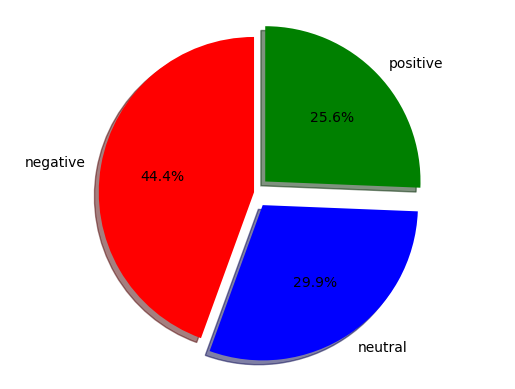

In [36]:
labels = table['index']
sizes = table['%']
explode = (0, 0.1, 0.1)

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90, colors = ['red', 'blue', 'green'])
ax1.axis('equal')  

plt.show()

### Vader sentiment distribution for the "Real" and "Fake" news

In [37]:
gr = df.groupby(['label', 'vader_title_prediction']).count()
gr['%'] = np.round((gr['vader_text_prediction']/gr['vader_text_prediction'].sum()) * 100, 2)
gr

title  all_text  vader_text_prediction      %
label vader_title_prediction                                               
Fake  negative                 3673      3673                   3673  27.27
      neutral                  1605      1605                   1605  11.92
      positive                 1839      1839                   1839  13.65
True  negative                 2314      2314                   2314  17.18
      neutral                  2424      2424                   2424  18.00
      positive                 1614      1614                   1614  11.98

### Vader sentiment distribution for the "Real" news

In [38]:
true_group = df.loc[df['label'] == 'True']['vader_title_prediction'].value_counts().reset_index()
true_group['%'] = np.round((true_group['vader_title_prediction']/true_group['vader_title_prediction'].sum()) * 100, 2)
true_group

,index,vader_title_prediction,%
0,neutral,2424,38.16
1,negative,2314,36.43
2,positive,1614,25.41


### Vader sentiment distribution for the "Fake" news

In [39]:
fake_group = df.loc[df['label'] == 'Fake']['vader_title_prediction'].value_counts().reset_index()
fake_group['%'] = np.round((fake_group['vader_title_prediction']/fake_group['vader_title_prediction'].sum()) * 100, 2)
fake_group

,index,vader_title_prediction,%
0,negative,3673,51.61
1,positive,1839,25.84
2,neutral,1605,22.55


### Vader sentiment distribution for the "Real" and "Fake" news on graf

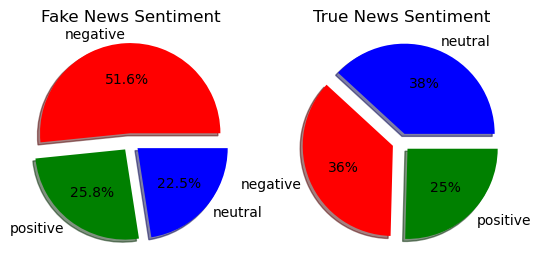

In [40]:
fake_labels = fake_group['index']
fake_fracs = fake_group['%']

true_labels = true_group['index']
true_fracs  = true_group['%']

# Make figure and axes
fig, axs = plt.subplots(1, 2)

# A standard pie plot
axs[0].pie(fake_fracs, labels=fake_labels, autopct='%1.1f%%', shadow=True, explode=(0.1, 0.1, 0.1), colors = ['red', 'green', 'blue'])
axs[0].set_title("Fake News Sentiment")

# Shift the second slice using explode
axs[1].pie(true_fracs, labels=true_labels, autopct='%.0f%%', shadow=True, explode=(0.1, 0.1, 0.1), colors = ['blue', 'red', 'green'])
axs[1].set_title("True News Sentiment")

plt.show()

## Find a sentiment of 5 titels from site https://edition.cnn.com/audio/podcasts/5-things

### (update every 3 hours)

In [41]:
from bs4 import BeautifulSoup as bs
pd.set_option('display.max_colwidth', 500)
import requests

In [42]:
page = requests.get("https://edition.cnn.com/audio/podcasts/5-things")
page

<Response [200]>

In [43]:
soup = bs(page.content)
quotes = [i.text for i in soup.find_all(slot="description")]
df_ = pd.DataFrame()
dfq = pd.DataFrame()
df_['Quotes'] = quotes
dfq['Quotes splitted'] = nltk.sent_tokenize(df_['Quotes'][1])
dfq['vader_prediction'] = dfq['Quotes splitted'].apply(predict_sentiment)
dfq

,Quotes splitted,vader_prediction
0,A January 6 House select committee member has previewed what will be in included the panel's final report.,neutral
1,German authorities have arrested 25 people who allegedly plotted to overthrow the government.,negative
2,"Two attacks on North Carolina substations are being investigated, as thousands are still without power.",negative
3,The Democrats' win in Georgia is good news for President Joe Biden's 2024 plans.,positive
4,"Plus, two women are suing Apple because they say their exes used AirTags to stalk them.",negative


In [44]:
labels = dfq['vader_prediction'].value_counts().reset_index()
labels

,index,vader_prediction
0,negative,3
1,neutral,1
2,positive,1


## Using NLTK modul, find the most common word trigrams in the real and fake news

In [45]:
from nltk.util import ngrams, bigrams, trigrams

In [46]:
words_in_grams = 3
def get_grams(text):
    token = nltk.word_tokenize(text)
    #grams_list = list(trigrams(token))
    grams_list = ngrams(token , words_in_grams)
    fdist = FreqDist(grams_list)
    
    fdist.plot(30, cumulative=False)
    
    return fdist.most_common(25)

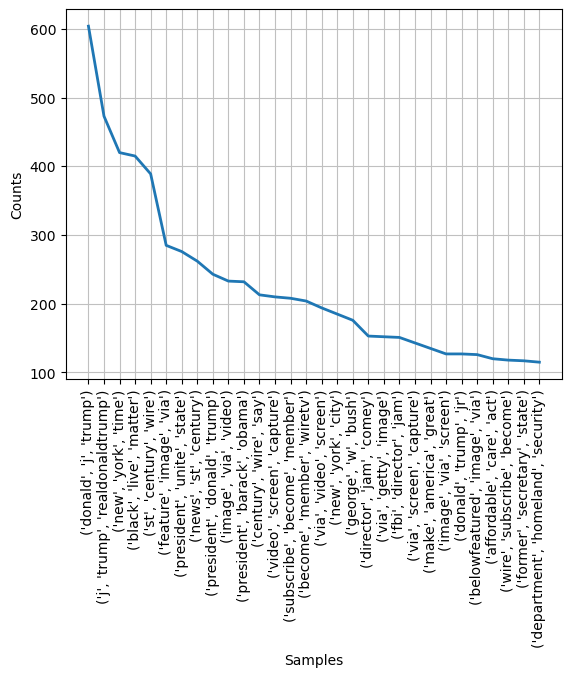

[(('donald', 'j', 'trump'), 604), (('j', 'trump', 'realdonaldtrump'), 473), (('new', 'york', 'time'), 420), (('black', 'live', 'matter'), 415), (('st', 'century', 'wire'), 389), (('feature', 'image', 'via'), 285), (('president', 'unite', 'state'), 276), (('news', 'st', 'century'), 262), (('president', 'donald', 'trump'), 243), (('image', 'via', 'video'), 233), (('president', 'barack', 'obama'), 232), (('century', 'wire', 'say'), 213), (('video', 'screen', 'capture'), 210), (('subscribe', 'become', 'member'), 208), (('become', 'member', 'wiretv'), 204), (('via', 'video', 'screen'), 194), (('new', 'york', 'city'), 185), (('george', 'w', 'bush'), 176), (('director', 'jam', 'comey'), 153), (('via', 'getty', 'image'), 152), (('fbi', 'director', 'jam'), 151), (('via', 'screen', 'capture'), 143), (('make', 'america', 'great'), 135), (('image', 'via', 'screen'), 127), (('donald', 'trump', 'jr'), 127)]


In [47]:
print(get_grams(fnews_text))

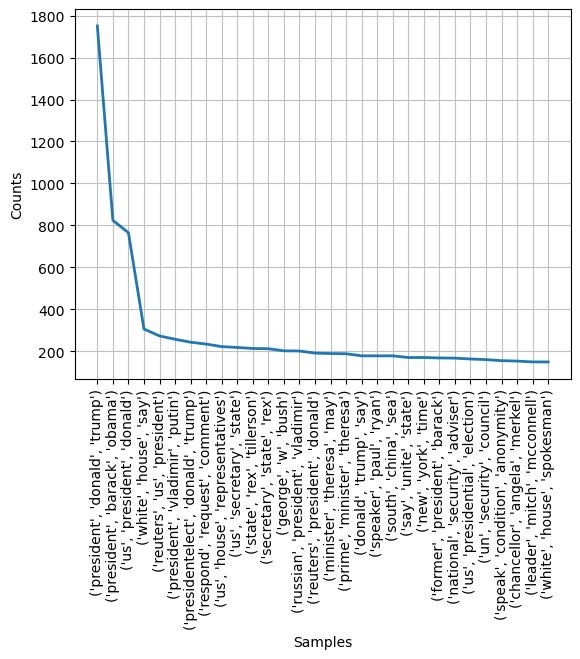

[(('president', 'donald', 'trump'), 1751), (('president', 'barack', 'obama'), 824), (('us', 'president', 'donald'), 765), (('white', 'house', 'say'), 306), (('reuters', 'us', 'president'), 273), (('president', 'vladimir', 'putin'), 257), (('presidentelect', 'donald', 'trump'), 243), (('respond', 'request', 'comment'), 234), (('us', 'house', 'representatives'), 222), (('us', 'secretary', 'state'), 218), (('state', 'rex', 'tillerson'), 213), (('secretary', 'state', 'rex'), 212), (('george', 'w', 'bush'), 202), (('russian', 'president', 'vladimir'), 201), (('reuters', 'president', 'donald'), 191), (('minister', 'theresa', 'may'), 189), (('prime', 'minister', 'theresa'), 188), (('donald', 'trump', 'say'), 178), (('speaker', 'paul', 'ryan'), 178), (('south', 'china', 'sea'), 178), (('say', 'unite', 'state'), 170), (('new', 'york', 'time'), 170), (('former', 'president', 'barack'), 168), (('national', 'security', 'adviser'), 167), (('us', 'presidential', 'election'), 163)]


In [48]:
print(get_grams(rnews_text))